<a href="https://colab.research.google.com/github/nsidhu11/CMPT419/blob/Assignment2/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from sklearn.model_selection import LeaveOneOut, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, mean_absolute_error, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.calibration import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.base import clone
from numpy import mean
from sklearn.metrics import confusion_matrix
from numpy import std

Accuracy: 0.9745370370370371
Confusion Matrix:
 [[294   0   0   0]
 [  0  97   5   1]
 [  0   1  13   1]
 [  0   1   2  17]]


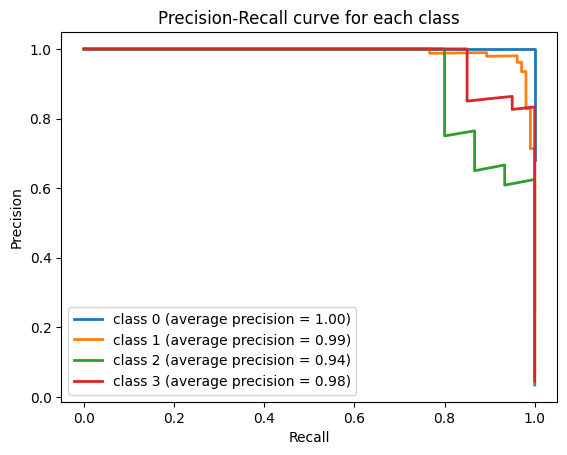

In [5]:

# <------------------ Part 1 ------------------>

# Load the dataset from your local machine
column_names = ['buying', 'maintainence', 'doors', 'people','boot','safety','class']
car_data = pd.read_csv('/content/sample_data/car.data',names = column_names)

mapping = {
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'people': {'2': 0, '4': 1, 'more': 2},
    'boot': {'small': 0, 'med': 1, 'big': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2},
}

# Apply mappings
for feature, feature_map in mapping.items():
    car_data[feature] = car_data[feature].map(feature_map)

categorical_features = ['buying', 'maintainence']
categorical_transformer = OneHotEncoder()
# Encode categorical variables
encoder = LabelEncoder()
for column in car_data.columns[:-1]:  # Assuming the last column is the target variable
    car_data[column] = encoder.fit_transform(car_data[column])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ], remainder='passthrough')

# Splitting the dataset
X = car_data.drop('class', axis=1)
y = car_data['class'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})  # assuming 'class' is the target
#y=df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
# model = RandomForestClassifier(n_estimators=100, random_state=42)
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4,seed=42)
#model = KNeighborsClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# print(model.score(X_train,y_train))

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:\n", cm)

for i in range(len(np.unique(y))):
    # Adapt predictions and labels for a one-vs-rest view of the current class
    y_test_bin = (y_test == i).astype(int)
    y_score = model.predict_proba(X_test)[:, i]

    precision, recall, _ = precision_recall_curve(y_test_bin, y_score)
    average_precision = average_precision_score(y_test_bin, y_score)

    plt.plot(recall, precision, lw=2, label=f'class {i} (average precision = {average_precision:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="best")
plt.show()

[-0.0023148148148147696, -0.0023148148148147696, 0.0, 0.0, 0.0023148148148148806, 0.0, 0.0, 0.0, 0.0, 0.0]


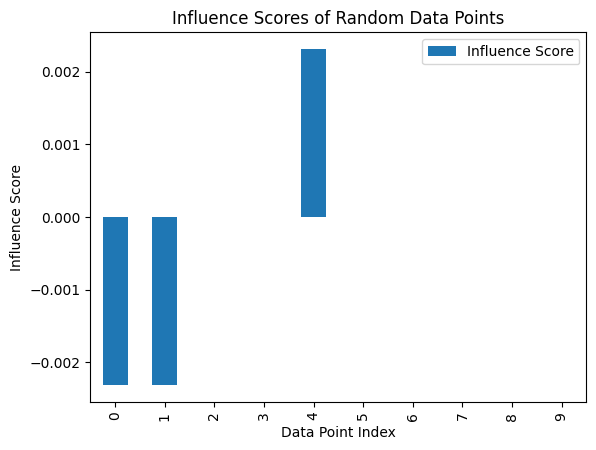

In [11]:
#<------------- Part 2 ---------------->
random_data_points = X_train.sample(n=10, random_state=np.random.randint(10000))
# print(random_data_points)
influence_scores = []
for i, data_point in random_data_points.iterrows():
    # select_random = random_data_points.sample(n=1, random_state=np.random.randint(10000))
    x_1 = X_train.drop(i)
    y_1 = y_train.drop(i)
    # print(x_1.shape, y_1.shape)
    # print(x_1)
    # print(y_1)
    model_loo =  clone(model)#xgb.XGBClassifier(objective='multi:softmax', num_class=4,seed=42)
    model_loo.fit(x_1,y_1)
    y_pred_loo = model_loo.predict(X_test)

    loo_accuracy = accuracy_score(y_test, y_pred_loo)
    influence_scores.append(accuracy - loo_accuracy)

print(influence_scores)
influence_df = pd.DataFrame({
    'Influence Score': influence_scores
})

# Plot the influence scores
influence_df.plot(kind='bar')
plt.xlabel('Data Point Index')
plt.ylabel('Influence Score')
plt.title('Influence Scores of Random Data Points')
plt.show()

0.9722222222222222
[0.0023148148148148806]
0.9722222222222222
[0.0023148148148148806, 0.0023148148148148806]
0.9768518518518519
[0.0023148148148148806, 0.0023148148148148806, -0.0023148148148147696]
0.9745370370370371
[0.0023148148148148806, 0.0023148148148148806, -0.0023148148148147696, 0.0]
0.9652777777777778
[0.0023148148148148806, 0.0023148148148148806, -0.0023148148148147696, 0.0, 0.0092592592592593]
0.9421296296296297
[0.0023148148148148806, 0.0023148148148148806, -0.0023148148148147696, 0.0, 0.0092592592592593, 0.03240740740740744]
0.9513888888888888
[0.0023148148148148806, 0.0023148148148148806, -0.0023148148148147696, 0.0, 0.0092592592592593, 0.03240740740740744, 0.02314814814814825]
0.9004629629629629
[0.0023148148148148806, 0.0023148148148148806, -0.0023148148148147696, 0.0, 0.0092592592592593, 0.03240740740740744, 0.02314814814814825, 0.07407407407407418]


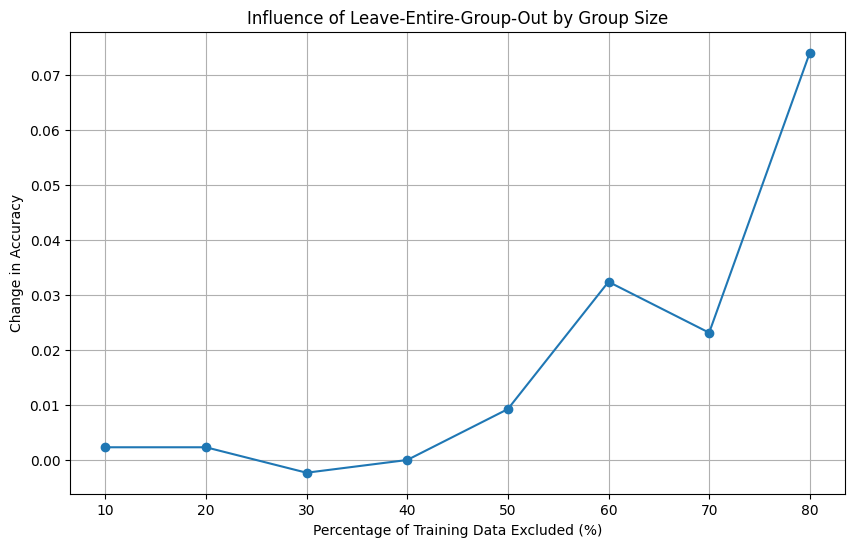

In [12]:
#<------------ Part 3---------------->
baseline_accuracy = accuracy_score(y_test, model.predict(X_test))
# Define group sizes as percentages of the training dataset
group_sizes = np.arange(0.1, 0.9, 0.1)  # From 10% to 100%, in 10% increments
influence_scores = []

for size in group_sizes:
    # Determine number of samples to exclude
    exclude_size = int(size * len(X_train))

    # Randomly select indices to exclude
    exclude_indices = np.random.choice(X_train.index, size=exclude_size, replace=False)

    # Exclude selected indices from training data
    X_train_reduced = X_train.drop(exclude_indices)
    y_train_reduced = y_train.drop(exclude_indices)

    # Retrain model on reduced dataset
    model.fit(X_train_reduced, y_train_reduced)
    reduced_accuracy = accuracy_score(y_test, model.predict(X_test))
    print(reduced_accuracy)

    # Influence score is change in accuracy
    influence_score = baseline_accuracy - reduced_accuracy
    influence_scores.append(influence_score)
    print(influence_scores)

# Plot influence scores vs. group sizes
plt.figure(figsize=(10, 6))
plt.plot(group_sizes * 100, influence_scores, marker='o')
plt.title('Influence of Leave-Entire-Group-Out by Group Size')
plt.xlabel('Percentage of Training Data Excluded (%)')
plt.ylabel('Change in Accuracy')
plt.grid(True)
plt.show()

1000


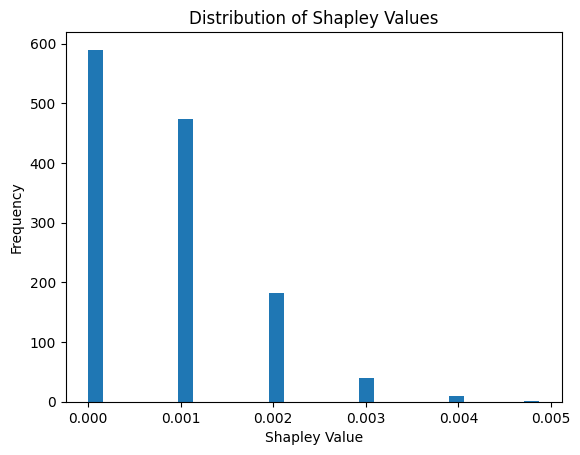

In [13]:
#<----------------- Part 4 ---------------->
def V(S, A, test_data, test_labels):
    # Train the model on the subset S of the training data and evaluate its performance on the test set
    if len(S) == 0:
        return 0.0
    A_clone = clone(A)
    A_clone.fit(X_train, y_train)
    predictions = A_clone.predict(test_data)
    return accuracy_score(test_labels, predictions)

def truncated_monte_carlo_shapley(train_data, train_labels, test_data, test_labels, A, performance_tolerance, n_permutations=1000):
    n = len(train_data)
    phi = np.zeros(n)
    V_D = V(range(n), A, test_data, test_labels)
    count = 0
    for _ in range(n_permutations):
        count=count+1
        permutation = np.random.permutation(n)
        V_previous = 0
        for j in range(n):
            if abs(V_D - V_previous) < performance_tolerance:
                V_current = V_previous
            else:
                S = permutation[:j+1]
                V_current = V(S, A, test_data, test_labels)
            phi[permutation[j]] += (V_current - V_previous) / n_permutations
            V_previous = V_current
    print(count)
    return phi


A =  xgb.XGBClassifier(objective='multi:softmax', num_class=4,seed=42) #RandomForestClassifier()
shapley_values = truncated_monte_carlo_shapley(X_train, y_train, X_test, y_test, A, performance_tolerance=0.01)

plt.hist(shapley_values, bins=30)
plt.title('Distribution of Shapley Values')
plt.xlabel('Shapley Value')
plt.ylabel('Frequency')
plt.show()